# Carlini&Wagner Attack against CIFAR-10 dataset

## Import libraries

In [4]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import numpy as np

## Load Resnet-50 and CIFAR-10 datasets

In [5]:
from torch.utils.data import random_split

# Training dataset (80% train / 20% validation)
dataset_train = CIFAR10('./data', train=True, download=True, transform = transforms.Compose([transforms.ToTensor()]))
random_seed = 42
torch.manual_seed(random_seed)
val_size = int(0.2*len(dataset_train)) # Validation size
train_size = int(len(dataset_train)-val_size) # Training size
train_ds, val_ds = random_split(dataset_train, [train_size, val_size]) # Dataset for training phase
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128*2, shuffle=True, num_workers=2) # Training data loader
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=128*2, shuffle=True, num_workers=2) # Validation data loader

# Testing dataset
test_ds = CIFAR10('./data', train=False, download=True,transform=transforms.Compose([transforms.ToTensor()])) # Testing dataset
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=128*2, shuffle=True, num_workers=2) # Testing data loader

# Load a pre-trained RESNET-50 model for training
model = models.resnet50(pretrained=True)

Files already downloaded and verified
Files already downloaded and verified


c:\Users\uelorriaga\OneDrive - IKERLAN S.COOP\Escritorio\TFG_Attacks\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\uelorriaga\OneDrive - IKERLAN S.COOP\Escritorio\TFG_Attacks\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

mean, std = get_mean_and_std(test_dl)
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.4949, 0.4862, 0.4507])
Std: tensor([0.2471, 0.2433, 0.2621])


torch.Size([256, 3, 32, 32])


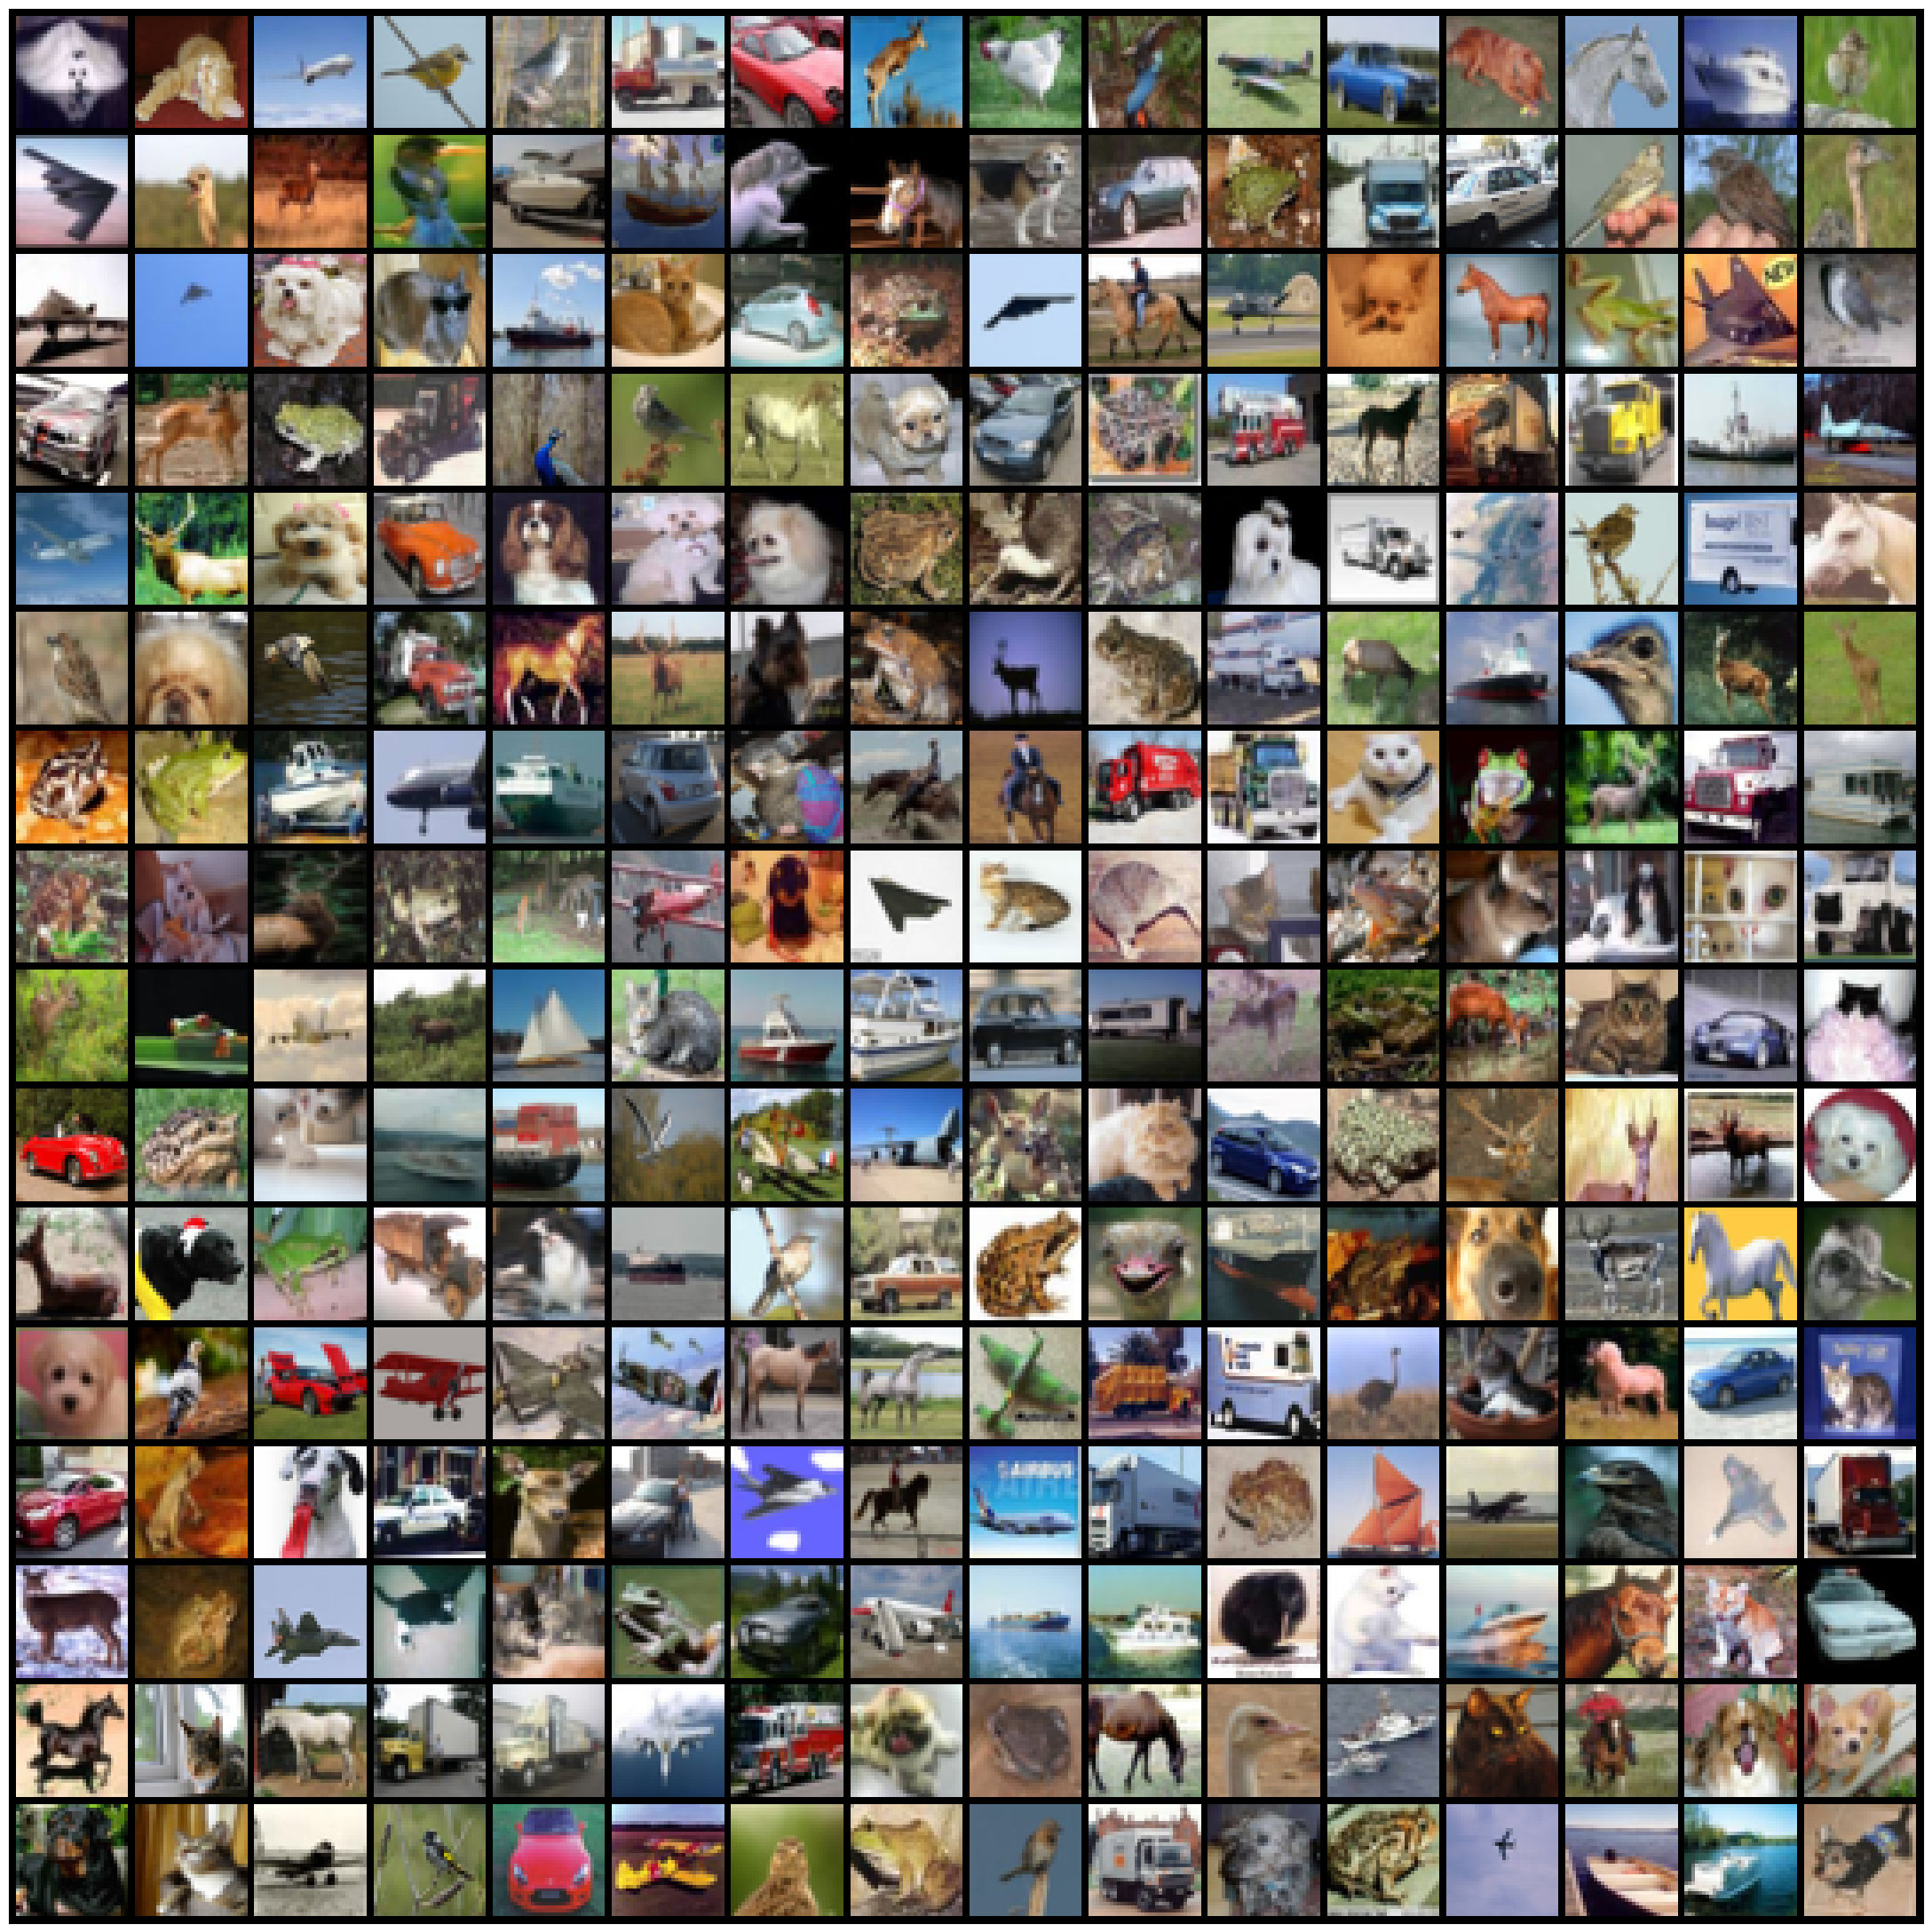

In [7]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        print(images.shape)
        fig, ax = plt.subplots(figsize=(28, 28))
        ax.set_xticks([]); ax.set_yticks([])
        # ax.imshow(make_grid(to_device(transforms.Normalize(-np.array(mean)/std, 1.0/np.array(std))(images),"cpu"), nrow=16).permute(1, 2, 0)) ##denormalize
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0)) ##denormalize
        break

show_batch(test_dl)

## Resnet-50 fine-tuning with CIFAR-10

In [10]:
# Freeze all layers in the model
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer for CIFAR-10 number of classes
# CIFAR-10 has 10 classes
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Optimize only the parameters of the final layer
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

def train_model(model, train_dl, val_dl, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_dl:
            # Move data to GPU if available
            images, labels = images, labels

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_dl.dataset)
        train_losses.append(epoch_loss)
        
        # Validation loss
        model.eval()
        with torch.no_grad():
            val_running_loss = 0.0
            for images, labels in val_dl:
                images, labels = images, labels
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)

            val_loss = val_running_loss / len(val_dl.dataset)
            val_losses.append(val_loss)

        print(f'Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

    print('Finished Training')
    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_dl, val_dl, criterion, optimizer, num_epochs=20)

Epoch 1, Train Loss: 1.7267, Validation Loss: 1.5938
Epoch 2, Train Loss: 1.5104, Validation Loss: 1.5027
Epoch 3, Train Loss: 1.4478, Validation Loss: 1.4713
Epoch 4, Train Loss: 1.4088, Validation Loss: 1.4581
Epoch 5, Train Loss: 1.3774, Validation Loss: 1.4230
Epoch 6, Train Loss: 1.3553, Validation Loss: 1.4340
Epoch 7, Train Loss: 1.3374, Validation Loss: 1.4119
Epoch 8, Train Loss: 1.3186, Validation Loss: 1.4367
Epoch 9, Train Loss: 1.3100, Validation Loss: 1.4194
Epoch 10, Train Loss: 1.2956, Validation Loss: 1.4112
Epoch 11, Train Loss: 1.2834, Validation Loss: 1.3978
Epoch 12, Train Loss: 1.2774, Validation Loss: 1.4157
Epoch 13, Train Loss: 1.2736, Validation Loss: 1.3875
Epoch 14, Train Loss: 1.2662, Validation Loss: 1.4227
Epoch 15, Train Loss: 1.2674, Validation Loss: 1.4023
Epoch 16, Train Loss: 1.2581, Validation Loss: 1.4024
Epoch 17, Train Loss: 1.2522, Validation Loss: 1.4200
Epoch 18, Train Loss: 1.2619, Validation Loss: 1.4247
Epoch 19, Train Loss: 1.2412, Validat

In [11]:
# Save finetuned resnet_50 model
torch.save(model, './resnet_50.pth')


In [12]:
# Load resnet_50 model
model = torch.load('./resnet_50.pth')
model.eval()  # Set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Custom Convolutional Neural Network to train CIFAR-10

In [14]:
import torch.nn.functional as F

class Cifar10CNN(nn.Module):
    def __init__(self, pNumClasses, pNumInputSize, pNumChannels):
        
        super(Cifar10CNN, self).__init__()

        self.conv_1 = nn.Sequential(
            nn.Conv2d(pNumChannels, pNumInputSize, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        
        self.conv_2 = nn.Sequential(
            nn.Conv2d(pNumInputSize, pNumInputSize*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        self.conv_3 = nn.Sequential(
            nn.Conv2d(pNumInputSize*2, pNumInputSize*4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        self.conv_4 = nn.Sequential(
            nn.Conv2d(pNumInputSize*4, pNumInputSize*4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        
        self.network = nn.Sequential(
            self.conv_1, # Convolution Layer 1: output dimension 32-3+1 = 30
            self.conv_2, # Convolution Layer 2: output dimension 30-3+1 = 28
            nn.MaxPool2d(kernel_size=2, stride=2), # Pooling Layer 1: output dimension 28/2 = 14
            self.conv_3, # Convolution Layer 3: output dimension 14-3+1 = 12
            self.conv_4, # Convolution Layer 4: output dimension 12-3+1 = 10
            nn.MaxPool2d(kernel_size=2, stride=2), # Pooling Layer 2: 10/2 = 5
            nn.Flatten(), # Flatten Layer 1
            nn.Linear(pNumInputSize*4*8*8, 512),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512, pNumClasses) # Fully Connected Layer (CIFAR-10 has output 10 classes)
        )

    def forward(self, x):
        #return F.softmax(self.network(x),dim=1)
        return self.network(x)

cifarModel = Cifar10CNN(10, 32, 3)

optimizer = torch.optim.Adam(cifarModel.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

def train_model(model, train_dl, val_dl, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        # Training phase
        model.train()  # Set the model to training mode
        running_loss = 0.0
        for images, labels in train_dl:
            # Move data to the device the model is on, typically GPU if available
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()  # Zero the parameter gradients to ensure clean updates

            outputs = model(images)  # Forward pass: compute predicted outputs
            loss = criterion(outputs, labels)  # Calculate loss based on the criterion given

            loss.backward()  # Backpropagation, compute gradients
            optimizer.step()  # Apply gradients and update model parameters

            running_loss += loss.item() * images.size(0)  # Multiply loss by the batch size for total loss

        epoch_loss = running_loss / len(train_dl.dataset)  # Calculate average loss over the entire dataset
        train_losses.append(epoch_loss)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        with torch.no_grad():  # Disable gradient calculation for efficiency
            for images, labels in val_dl:
                if torch.cuda.is_available():
                    images, labels = images.cuda(), labels.cuda()

                outputs = model(images)  # Compute predictions
                loss = criterion(outputs, labels)  # Calculate loss
                val_running_loss += loss.item() * images.size(0)  # Aggregate loss

            val_loss = val_running_loss / len(val_dl.dataset)  # Average loss over validation set
            val_losses.append(val_loss)

        print(f'Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

    print('Finished Training')
    return train_losses, val_losses

train_losses, val_losses = train_model(cifarModel, train_dl, val_dl, loss_function, optimizer, num_epochs=10)

Epoch 1, Train Loss: 1.8434, Validation Loss: 1.6635
Epoch 2, Train Loss: 1.3905, Validation Loss: 1.3733
Epoch 3, Train Loss: 1.2044, Validation Loss: 1.1991
Epoch 4, Train Loss: 1.0269, Validation Loss: 1.0221
Epoch 5, Train Loss: 0.8950, Validation Loss: 0.9639
Epoch 6, Train Loss: 0.7798, Validation Loss: 0.9018
Epoch 7, Train Loss: 0.6952, Validation Loss: 0.8442
Epoch 8, Train Loss: 0.6148, Validation Loss: 0.8181
Epoch 9, Train Loss: 0.5235, Validation Loss: 0.8021
Epoch 10, Train Loss: 0.4613, Validation Loss: 0.7856
Finished Training


In [16]:
# Save custom cifrar-10 trained cnn model
torch.save(cifarModel, './cifar_10_cnn.pth')

In [18]:
# Load resnet_50 model
cifarModel = torch.load('./cifar_10_cnn.pth')
cifarModel.eval()  # Set the model to evaluation mode

Cifar10CNN(
  (conv_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (conv_3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (conv_4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (network): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    

## Carlini&Wagner L2 attack against fine-tuned RESNET-50 and custom CNN

In [19]:
import torch.nn as nn

def cw_l2_attack(model, original_images, labels, targeted=False, c=1e-4, kappa=0, max_iter=1000, learning_rate=0.01):
    
    # Create a clone of the original images to modify
    perturbed_images = torch.zeros_like(original_images, requires_grad=True).to("cpu")

    # Define the optimizer for the perturbed images
    optimizer = optim.Adam([perturbed_images], lr=learning_rate)

    for iteration in range(max_iter):

        # Convert the perturbed image into the TanH space
        perturbed_images_tanh = 1/2*(nn.Tanh()(perturbed_images) + 1)

        # Forward pass
        outputs = model(perturbed_images_tanh)
        # Ensure labels are one-hot encoded and match the output size of the model
        labels_one_hot = torch.eye(len(outputs[0]))[labels].to(original_images.device)

        # Calculate the loss
        i, _ = torch.max((1-labels_one_hot)*outputs, dim=1)
        j = torch.masked_select(outputs, labels_one_hot.bool())
        if targeted:
            loss = torch.clamp(i-j, min=-kappa)
        else:
            loss = torch.clamp(j-i, min=-kappa)

        # Adding perturbation regularization
        l2dist = torch.norm(perturbed_images_tanh - original_images, p=2)
        #l2dist = nn.MSELoss(reduction='sum')(perturbed_images_tanh, original_images)
        loss = l2dist + torch.sum(c * loss)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if iteration % (max_iter // 10) == 0:
            print(f'Iteration {iteration}: Loss {loss.item()}')
    perturbed_images = 1/2*(nn.Tanh()(perturbed_images) + 1)
    return perturbed_images

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [20]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_images(imgs, titles):
    fig, axs = plt.subplots(1, len(imgs), figsize=(15, 5))  # Create 1 row of subplots
    for i, img in enumerate(imgs):
        if isinstance(img, torch.Tensor):
            img = img.detach().cpu().numpy()  # Convert PyTorch tensor to NumPy array

        if img.ndim == 4 and img.shape[0] == 1:  # Remove singleton batch dimension if present
            img = img.squeeze(0)
        elif img.ndim == 2:  # Handle grayscale image (no channel dimension)
            img = np.stack((img,)*3, axis=-1)  # Convert to RGB by duplicating the channels

        if img.ndim == 3 and img.shape[0] == 3:  # Correct format (C, H, W) to (H, W, C)
            img = np.transpose(img, (1, 2, 0))

        axs[i].imshow(img)
        axs[i].axis('off')  # Hide axes
        axs[i].set_title(titles[i])  # Set the title for each subplot

    plt.show()

Original Image & Label:


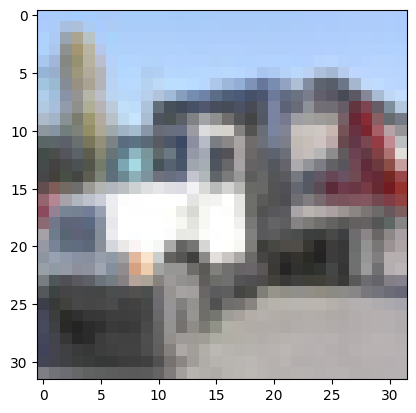

Label: 9
Iteration 0: Loss 13.609078407287598
Iteration 1000: Loss 1.4811227321624756
Iteration 2000: Loss 1.026016354560852
Iteration 3000: Loss 0.5619255304336548
Iteration 4000: Loss 0.5503419041633606
Iteration 5000: Loss 0.7369489073753357
Iteration 6000: Loss 0.978024423122406
Iteration 7000: Loss 0.6905024647712708
Iteration 8000: Loss 0.7703866958618164
Iteration 9000: Loss 0.4075010418891907
Perturbed Image & Predicted Label:


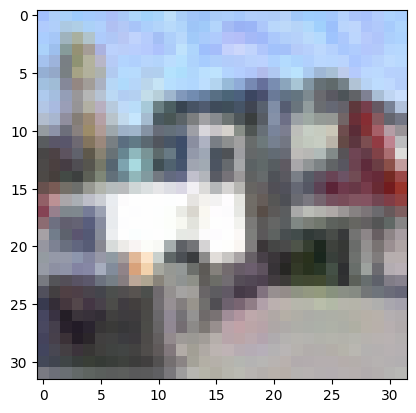

Predicted Label after attack: 8
Perturbation:


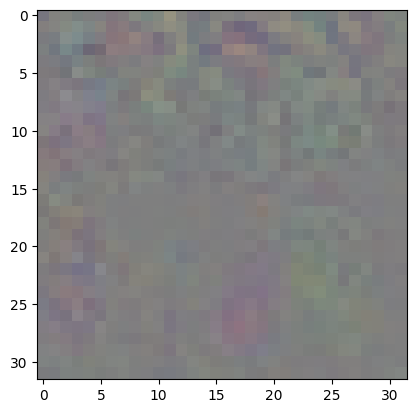

In [34]:
import torch.nn as nn

specific_index = 45  # Example index you want to access
subset = Subset(test_ds, [specific_index])
loader = DataLoader(subset, batch_size=1)  # Ensure batch size matches what you need

# Example of running the attack
dataiter = iter(loader)
original_image, label = next(dataiter)

# Display original and perturbed images
print("Original Image & Label:")
imshow(torchvision.utils.make_grid(original_image))
print('Label:', label.item())

# Run the attack
perturbed_image = cw_l2_attack(model, original_image, label, c=1, targeted=False, max_iter=10000)

print("Perturbed Image & Predicted Label:")
imshow(torchvision.utils.make_grid(perturbed_image.detach()))

# Evaluate model on perturbed image
output = model(perturbed_image)
pred_label = output.max(1, keepdim=True)[1]
print('Predicted Label after attack:', pred_label.item())

# Show the perturbation
print("Perturbation:")
imshow(torchvision.utils.make_grid(perturbed_image.detach() -  original_image + 0.5))

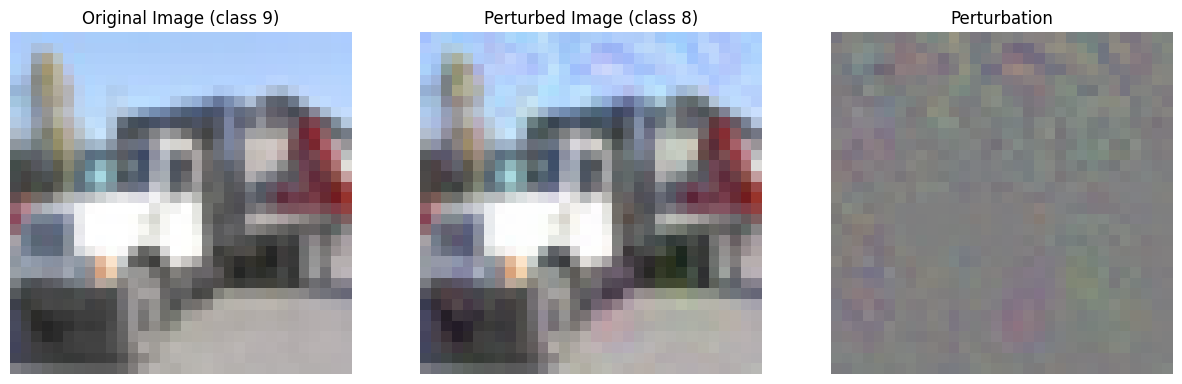

In [35]:
images = [original_image, perturbed_image.detach(), perturbed_image.detach() -  original_image + 0.5]
titles = [f"Original Image (class {label.item()})", f"Perturbed Image (class {pred_label.item()})", "Perturbation"]
show_images(images, titles)

Original Image & Label:


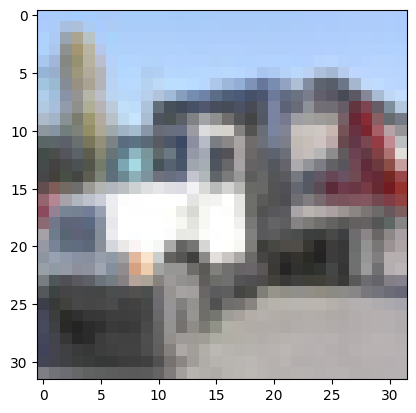

Label: 9
Iteration 0: Loss 13.609078407287598
Iteration 1000: Loss 0.48396798968315125
Iteration 2000: Loss 0.45267555117607117
Iteration 3000: Loss 0.45565399527549744
Iteration 4000: Loss 0.4674653708934784
Iteration 5000: Loss 0.4280870854854584
Iteration 6000: Loss 0.42946934700012207
Iteration 7000: Loss 0.5039666891098022
Iteration 8000: Loss 0.43197619915008545
Iteration 9000: Loss 0.4463519752025604
Perturbed Image & Predicted Label:


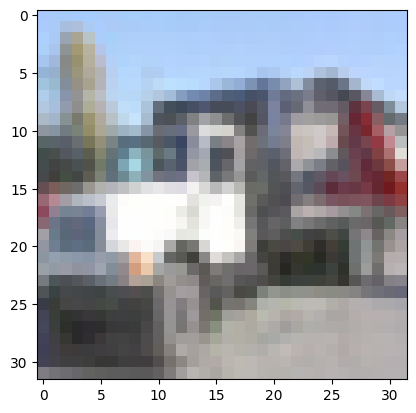

Predicted Label after attack: 7
Perturbation:


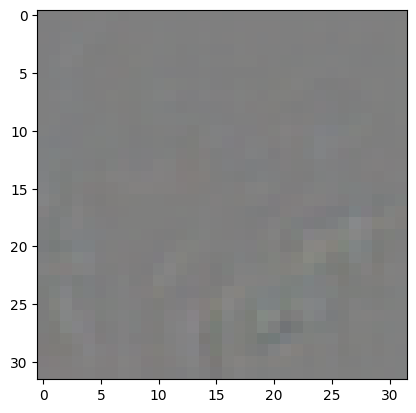

In [36]:
import torch.nn as nn

specific_index = 45  # Example index you want to access
subset = Subset(test_ds, [specific_index])
loader = DataLoader(subset, batch_size=1)  # Ensure batch size matches what you need

# Example of running the attack
dataiter = iter(loader)
original_image, label = next(dataiter)

# Display original and perturbed images
print("Original Image & Label:")
imshow(torchvision.utils.make_grid(original_image))
print('Label:', label.item())

# Run the attack
perturbed_image = cw_l2_attack(cifarModel, original_image, label, c=1, targeted=False, max_iter=10000)

print("Perturbed Image & Predicted Label:")
imshow(torchvision.utils.make_grid(perturbed_image.detach()))

# Evaluate model on perturbed image
output = cifarModel(perturbed_image)
pred_label = output.max(1, keepdim=True)[1]
print('Predicted Label after attack:', pred_label.item())

# Show the perturbation
print("Perturbation:")
imshow(torchvision.utils.make_grid(perturbed_image.detach() -  original_image + 0.5))

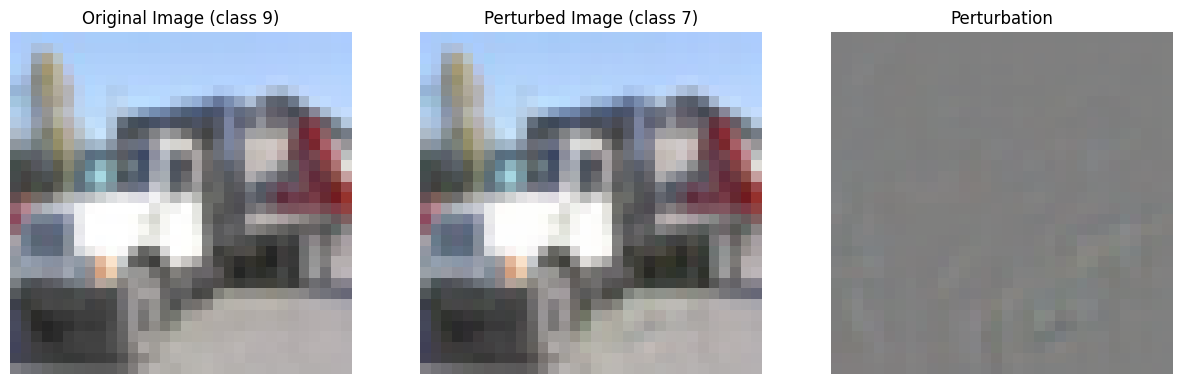

In [23]:
images = [original_image, perturbed_image.detach(), perturbed_image.detach() -  original_image + 0.5]
titles = [f"Original Image (class {label.item()})", f"Perturbed Image (class {pred_label.item()})", "Perturbation"]
show_images(images, titles)

In [32]:
from PIL import Image

def save_image(torch_image, filename):
    # Check the number of dimensions and act accordingly
    if torch_image.dim() == 3:
        # Assuming it's a single RGB image (C, H, W)
        image_array = torch_image.permute(1, 2, 0).numpy()
    elif torch_image.dim() == 2:
        # Grayscale image (H, W); expand dims to (H, W, C)
        image_array = np.expand_dims(torch_image.numpy(), axis=-1)
    elif torch_image.dim() == 4 and torch_image.size(0) == 1:
        # Single image in a batch
        image_array = torch_image.squeeze(0).permute(1, 2, 0).numpy()
    else:
        raise ValueError("Unsupported tensor shape")

    # Normalize and convert to uint8
    image_array = (image_array * 255).astype(np.uint8) if image_array.max() <= 1.0 else image_array.astype(np.uint8)

    # Save as PNG
    img = Image.fromarray(image_array)
    img.save(filename)

save_image(original_image,"original_image.png")